# IMPORT ALL RELEVANT LIBRARIES

In [1]:
# ------- [Import all relevant libraries] -------

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Usual Suspects
import numpy as np           # Mathematical operations
import pandas as pd          # Data manipulation

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

# String manipulation
import re

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# ML
# Models
import xgboost as xgb
import lightgbm as lgb

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Ridge

# ML Model Evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Time Series
!pip install optuna
import optuna

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

!pip install catboost
from catboost import CatBoostRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Display settings
pd.set_option('display.max_colwidth', None)
from IPython.display import display


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# LOAD DATA AND DO QUICK IDE

In [2]:
data = pd.read_csv("../Clean Data/data_no_feature_engineering.csv")

# Create a copy
df = data.copy(deep=True)

# --- IDE ---

# Check dataset shape
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

# Check columns
print('\n'+'--'*50)
print("Columns:")
display(df.columns)

# Check metadata
print('\n'+'--'*50)
print("Metadata Check:")
display(df.info())

# Check and remove duplicates
print('\n'+'--'*50)
print("Duplicates:", df.duplicated().sum())

# Drop duplicates
df.drop_duplicates(inplace=True)
print("Duplicates after dropping:", df.duplicated().sum())

# Check data completeness
print('\n'+'--'*50)
print("Missingness check:")
display(df.isna().sum())

The dataset has 79488 rows and 14 columns.

----------------------------------------------------------------------------------------------------
Columns:


Index(['country_name', 'managing_agency_name',
       'managing_subagency_or_bureau_name',
       'implementing_partner_category_name', 'implementing_partner_name',
       'us_category_name', 'us_sector_name', 'funding_agency_name',
       'foreign_assistance_objective_name', 'transaction_type_name',
       'fiscal_year', 'transaction_date', 'current_dollar_amount',
       'constant_dollar_amount'],
      dtype='object')


----------------------------------------------------------------------------------------------------
Metadata Check:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79488 entries, 0 to 79487
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   country_name                        79488 non-null  object 
 1   managing_agency_name                79488 non-null  object 
 2   managing_subagency_or_bureau_name   79488 non-null  object 
 3   implementing_partner_category_name  79488 non-null  object 
 4   implementing_partner_name           79488 non-null  object 
 5   us_category_name                    79488 non-null  object 
 6   us_sector_name                      79488 non-null  object 
 7   funding_agency_name                 79488 non-null  object 
 8   foreign_assistance_objective_name   79488 non-null  object 
 9   transaction_type_name               79488 non-null  o

None


----------------------------------------------------------------------------------------------------
Duplicates: 271
Duplicates after dropping: 0

----------------------------------------------------------------------------------------------------
Missingness check:


country_name                          0
managing_agency_name                  0
managing_subagency_or_bureau_name     0
implementing_partner_category_name    0
implementing_partner_name             0
us_category_name                      0
us_sector_name                        0
funding_agency_name                   0
foreign_assistance_objective_name     0
transaction_type_name                 0
fiscal_year                           0
transaction_date                      0
current_dollar_amount                 0
constant_dollar_amount                0
dtype: int64

# DATA WRANGLING

In [3]:
# Columns to drop
cols_to_drop = [
    'country_name',
    'transaction_date',
    'current_dollar_amount',
    'implementing_partner_name',
    'managing_subagency_or_bureau_name',
    'implementing_partner_category_name',
    'foreign_assistance_objective_name'
]

# Drop
df = df.drop(columns=cols_to_drop)
print("Remaining columns:")
display(df.columns)


Remaining columns:


Index(['managing_agency_name', 'us_category_name', 'us_sector_name',
       'funding_agency_name', 'transaction_type_name', 'fiscal_year',
       'constant_dollar_amount'],
      dtype='object')

In [4]:
df['is_refund'] = (df['constant_dollar_amount'] < 0).astype(int)

# Convert all dollar amounts to positive magnitudes
df['constant_dollar_amount'] = df['constant_dollar_amount'].abs()

print("Negative values remaining:", (df['constant_dollar_amount'] < 0).sum())
print("Refund transactions:", df['is_refund'].sum())

Negative values remaining: 0
Refund transactions: 8073


# BASIC EDA

managing_agency_name
U.S. Agency for International Development             63168
Department of State                                    6071
Department of Health and Human Services                3649
Department of the Treasury                             2022
African Development Foundation                         1748
Peace Corps                                             772
Department of Agriculture                               553
Department of the Interior                              429
Department of Defense                                   305
Trade and Development Agency                            166
Millennium Challenge Corporation                         76
Department of Energy                                     66
Department of Justice                                    54
Department of Labor                                      51
Department of Homeland Security                          30
Department of Transportation                             25
Department of Comme

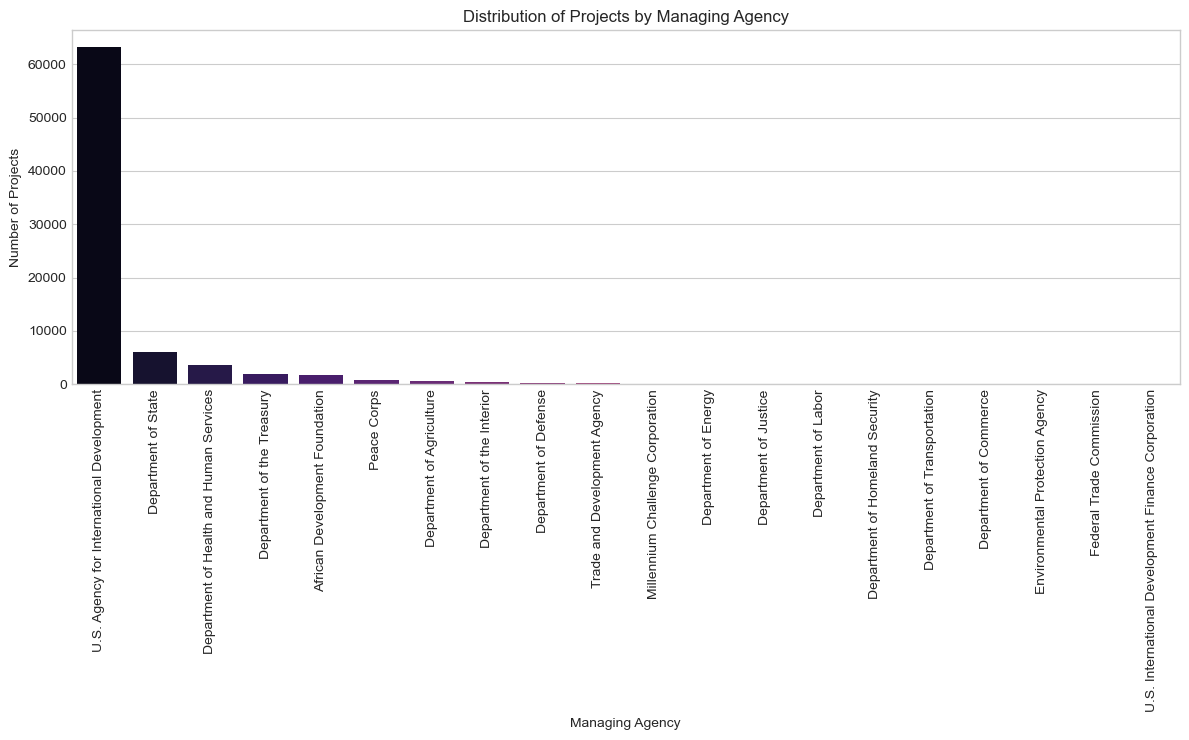

In [5]:
# --- Inspect managing agency counts ---
agency_counts = df['managing_agency_name'].value_counts()
display(agency_counts)

# --- Plot distribution ---
plt.figure(figsize=(12,7.5))
sns.barplot(x=agency_counts.index, y=agency_counts.values, palette="magma")
plt.xticks(rotation=90)
plt.title("Distribution of Projects by Managing Agency")
plt.ylabel("Number of Projects")
plt.xlabel("Managing Agency")
plt.tight_layout()
plt.show()

funding_agency_name
U.S. Agency for International Development             36101
Department of State                                   33644
Department of Agriculture                              3078
Department of the Treasury                             2022
African Development Foundation                         1748
Department of Health and Human Services                 878
Peace Corps                                             527
Department of the Interior                              416
Millennium Challenge Corporation                        241
Department of Defense                                   205
Trade and Development Agency                            133
Department of Energy                                     66
Department of Labor                                      51
Department of the Army                                   36
Department of Transportation                             23
Department of Commerce                                   13
Department of Justic

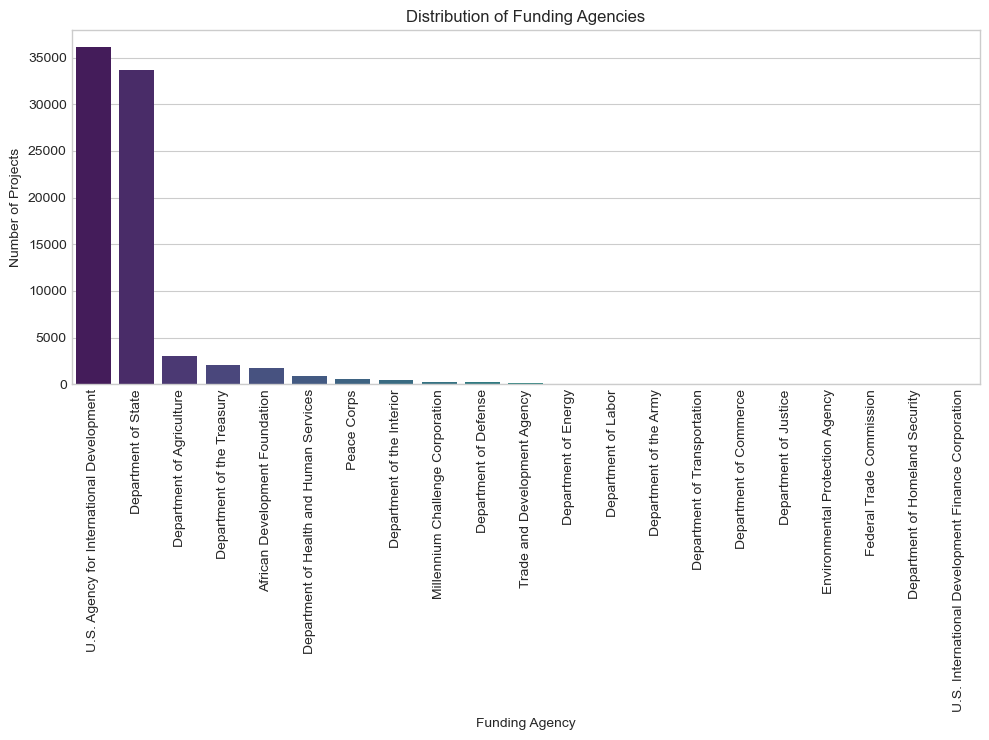

In [6]:
# Inspect funding agency name
agency_counts = df['funding_agency_name'].value_counts()
display(agency_counts)

# --- Plot distribution ---
plt.figure(figsize=(10,7.5))
sns.barplot(x=agency_counts.index, y=agency_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Distribution of Funding Agencies")
plt.ylabel("Number of Projects")
plt.xlabel("Funding Agency")
plt.tight_layout()
plt.show()

In [7]:
# inspect us category name
df['us_category_name'].value_counts()

us_category_name
Health                                     29303
Program Support                            21982
Economic Development                        9454
Humanitarian Assistance                     6220
Democracy, Human Rights, and Governance     4094
Education and Social Services               2734
Peace and Security                          2596
Environment                                 2547
Multi-sector                                 287
Name: count, dtype: int64

In [8]:
# Inspect us_sector_name
df['us_sector_name'].value_counts()

us_sector_name
Direct Administrative Costs                              21860
HIV/AIDS                                                 16596
Protection, Assistance and Solutions                      5860
Agriculture                                               4904
Family Planning and Reproductive Health                   2730
Macroeconomic Foundation for Growth                       2259
Maternal and Child Health                                 2213
Good Governance                                           2057
Malaria                                                   2014
Health - General                                          1759
Pandemic Influenza and Other Emerging Threats (PIOET)     1460
Clean Productive Environment                              1245
Basic Education                                           1239
Natural Resources and Biodiversity                        1228
Political Competition and Consensus-Building              1002
Nutrition                               

sector
Health                              28411
Governance & Administration         22198
Humanitarian & Social Protection     7219
Agriculture & Food Security          4904
Economic Growth & Development        4315
Governance & Human Rights            4216
Infrastructure & Environment         3759
Peace & Security                     2596
Education                            1599
Name: count, dtype: int64

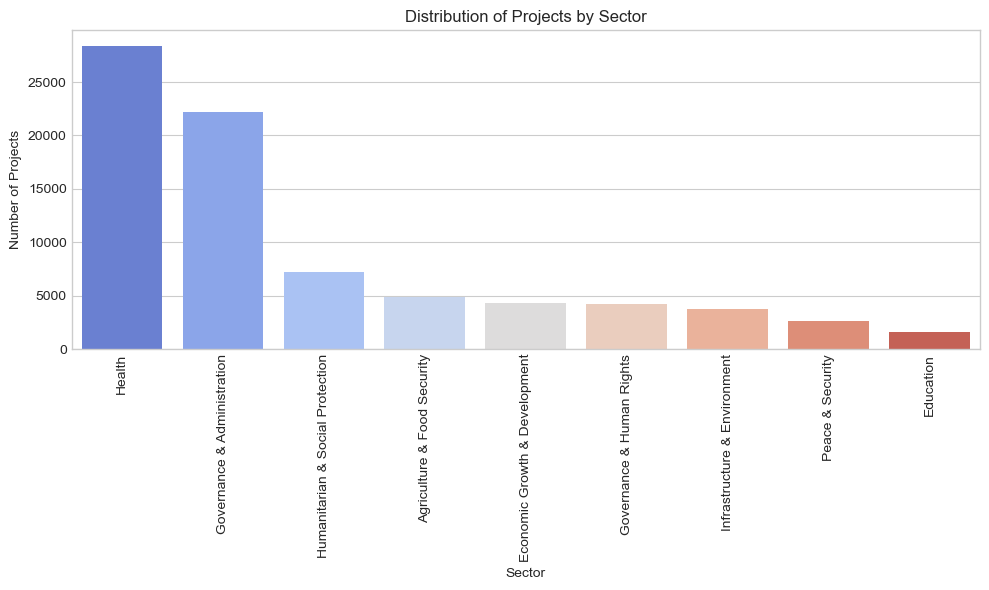

In [9]:
sector_mapping = {
    # --- Health ---
    'HIV/AIDS': 'Health',
    'Malaria': 'Health',
    'Tuberculosis': 'Health',
    'Maternal and Child Health': 'Health',
    'Family Planning and Reproductive Health': 'Health',
    'Health - General': 'Health',
    'Other Public Health Threats': 'Health',
    'Pandemic Influenza and Other Emerging Threats (PIOET)': 'Health',
    'Nutrition': 'Health',

    # --- Education ---
    'Basic Education': 'Education',
    'Higher Education': 'Education',
    'Education and Social Services - General': 'Education',

    # --- Governance & Human Rights ---
    'Rule of Law and Human Rights': 'Governance & Human Rights',
    'Good Governance': 'Governance & Human Rights',
    'Democracy, Human Rights, and Governance - General': 'Governance & Human Rights',
    'Civil Society': 'Governance & Human Rights',
    'Political Competition and Consensus-Building': 'Governance & Human Rights',
    'Monitoring and Evaluation': 'Governance & Human Rights',

    # --- Agriculture & Food Security ---
    'Agriculture': 'Agriculture & Food Security',

    # --- Economic Growth & Development ---
    'Economic Opportunity': 'Economic Growth & Development',
    'Economic Development - General': 'Economic Growth & Development',
    'Financial Sector': 'Economic Growth & Development',
    'Private Sector Competitiveness': 'Economic Growth & Development',
    'Trade and Investment': 'Economic Growth & Development',
    'Macroeconomic Foundation for Growth': 'Economic Growth & Development',
    'Policies, Regulations, and Systems': 'Economic Growth & Development',

    # --- Infrastructure & Environment ---
    'Infrastructure': 'Infrastructure & Environment',
    'Water Supply and Sanitation': 'Infrastructure & Environment',
    'Clean Productive Environment': 'Infrastructure & Environment',
    'Environment - General': 'Infrastructure & Environment',
    'Natural Resources and Biodiversity': 'Infrastructure & Environment',
    'Manufacturing': 'Infrastructure & Environment',
    'Mining and Natural Resources': 'Infrastructure & Environment',
    'Environment': 'Infrastructure & Environment',

    # --- Peace & Security ---
    'Stabilization Operations and Security Sector Reform': 'Peace & Security',
    'Counter-Terrorism': 'Peace & Security',
    'Counter-Narcotics': 'Peace & Security',
    'Conflict Mitigation and Reconciliation': 'Peace & Security',
    'Peace and Security - General': 'Peace & Security',
    'Transnational Crime': 'Peace & Security',
    'Combating Weapons of Mass Destruction (WMD)': 'Peace & Security',

    # --- Humanitarian & Social Protection ---
    'Protection, Assistance and Solutions': 'Humanitarian & Social Protection',
    'Disaster Readiness': 'Humanitarian & Social Protection',
    'Migration Management': 'Humanitarian & Social Protection',
    'Humanitarian Assistance - General': 'Humanitarian & Social Protection',
    'Social Services': 'Humanitarian & Social Protection',
    'Social Assistance': 'Humanitarian & Social Protection',

    # --- Governance & Administration ---
    'Direct Administrative Costs': 'Governance & Administration',
    'Multi-sector - Unspecified': 'Governance & Administration',
    'International Contributions': 'Governance & Administration',
    'Labor Policies and Markets': 'Governance & Administration',
}

# Apply mapping
df['sector'] = df['us_sector_name'].map(sector_mapping)
df.drop(columns='us_sector_name', inplace=True)

# --- Check distribution ---
sector_counts = df['sector'].value_counts(dropna=False)
display(sector_counts)

# --- Plot distribution ---
plt.figure(figsize=(10,6))
sns.barplot(x=sector_counts.index, y=sector_counts.values, palette="coolwarm")
plt.xticks(rotation=90, ha='center')
plt.title("Distribution of Projects by Sector")
plt.ylabel("Number of Projects")
plt.xlabel("Sector")
plt.tight_layout()
plt.show()

fiscal_year
2000      85
2001     434
2002     533
2003     581
2004     696
2005     764
2006    1298
2007    1843
2008    2071
2009    2863
2010    3258
2011    3631
2012    3612
2013    4394
2014    4428
2015    4056
2016    4173
2017    4629
2018    4218
2019    3968
2020    3739
2021    4598
2022    5287
2023    5716
2024    5764
2025    2578
Name: count, dtype: int64


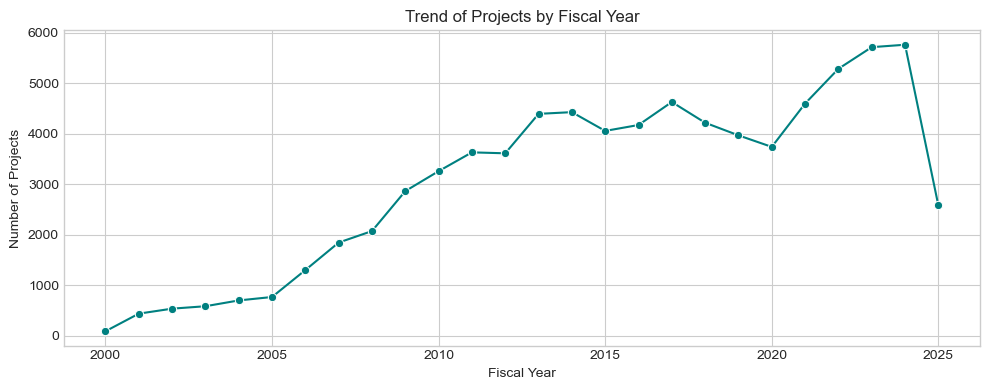

In [10]:
# --- Count projects per fiscal year ---
fy_counts = df['fiscal_year'].value_counts().sort_index()  # chronological order
print(fy_counts)

# --- Line plot ---
plt.figure(figsize=(10,4))
sns.lineplot(x=fy_counts.index, y=fy_counts.values, marker='o', color='teal')
plt.title("Trend of Projects by Fiscal Year")
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Projects")
plt.grid(True)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [11]:
# Drop us category name
df.drop(columns='us_category_name', inplace=True)

In [12]:
df = df.sort_values(['managing_agency_name', 'sector', 'fiscal_year']).reset_index(drop=True)
df.head()

,managing_agency_name,funding_agency_name,transaction_type_name,fiscal_year,constant_dollar_amount,is_refund,sector
0,African Development Foundation,African Development Foundation,Obligations,2010,16334.0,0,Agriculture & Food Security
1,African Development Foundation,African Development Foundation,Disbursements,2010,14972.0,0,Agriculture & Food Security
2,African Development Foundation,African Development Foundation,Obligations,2011,179929.0,0,Agriculture & Food Security
3,African Development Foundation,African Development Foundation,Disbursements,2011,77584.0,0,Agriculture & Food Security
4,African Development Foundation,African Development Foundation,Obligations,2011,109730.0,0,Agriculture & Food Security


# FEATURE ENGINEERING

In [13]:
# --- FEATURE ENGINEERING ---
group_cols = ['managing_agency_name', 'sector']
target_col = 'constant_dollar_amount'

# Define lag periods and rolling windows
lags = [1, 2]
rolling_windows = [3]

# --- Lag features ---
for lag in lags:
    df[f'lag_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)

# --- Rolling mean and std ---
for window in rolling_windows:
    df[f'rolling_mean_{window}yr'] = df.groupby(group_cols)[target_col].transform(
        lambda x: x.shift(1).rolling(window, min_periods=1).mean()
    )
    df[f'rolling_std_{window}yr'] = df.groupby(group_cols)[target_col].transform(
        lambda x: x.shift(1).rolling(window, min_periods=1).std()
    )

# --- Growth rate ---
df['funding_growth_rate'] = df.groupby(group_cols)[target_col].pct_change()

# --- Fill NaNs with 0 ---
feat_cols = [f'lag_{lag}' for lag in lags] + \
            [f'rolling_mean_{w}yr' for w in rolling_windows] + \
            [f'rolling_std_{w}yr' for w in rolling_windows] + \
            ['funding_growth_rate']

df[feat_cols] = df[feat_cols].fillna(0)

# Preview
df.head(10)

,managing_agency_name,funding_agency_name,transaction_type_name,fiscal_year,constant_dollar_amount,is_refund,sector,lag_1,lag_2,rolling_mean_3yr,rolling_std_3yr,funding_growth_rate
0,African Development Foundation,African Development Foundation,Obligations,2010,16334.0,0,Agriculture & Food Security,0.0,0.0,0.000000,0.000000,0.000000
1,African Development Foundation,African Development Foundation,Disbursements,2010,14972.0,0,Agriculture & Food Security,16334.0,0.0,16334.000000,0.000000,-0.083384
2,African Development Foundation,African Development Foundation,Obligations,2011,179929.0,0,Agriculture & Food Security,14972.0,16334.0,15653.000000,963.079436,11.017700
3,African Development Foundation,African Development Foundation,Disbursements,2011,77584.0,0,Agriculture & Food Security,179929.0,14972.0,70411.666667,94847.237632,-0.568808
4,African Development Foundation,African Development Foundation,Obligations,2011,109730.0,0,Agriculture & Food Security,77584.0,179929.0,90828.333333,83272.217674,0.414338
5,African Development Foundation,African Development Foundation,Disbursements,2011,43363.0,0,Agriculture & Food Security,109730.0,77584.0,122414.333333,52338.265068,-0.604821
6,African Development Foundation,African Development Foundation,Obligations,2011,12010.0,0,Agriculture & Food Security,43363.0,109730.0,76892.333333,33188.905892,-0.723036
7,African Development Foundation,African Development Foundation,Obligations,2011,1334.0,0,Agriculture & Food Security,12010.0,43363.0,55034.333333,49894.534935,-0.888926
8,African Development Foundation,African Development Foundation,Disbursements,2011,1241.0,0,Agriculture & Food Security,1334.0,12010.0,18902.333333,21845.763991,-0.069715
9,African Development Foundation,African Development Foundation,Obligations,2011,314788.0,0,Agriculture & Food Security,1241.0,1334.0,4861.666667,6190.812898,252.656728


## VANILLA ENSEMBLE REGRESSORS

We train unparameterised versions of Random Forest, XGBoost, LightGBM and CatBoost regressors to predict funding allocations and evaluate them on R-Squared (explained variance), RMSE and MAE.

We also train stacked ensembles of our best tree regressors and evaluate their performance against our chosen baseline model.

In [14]:
# --- ML PIPELINES FOR RANDOM FOREST, XGBOOST, LIGHTGBM AND CATBOOST ---

# --- 1. Separate features and target ---
X = df.drop('constant_dollar_amount', axis=1)
y = np.log1p(df['constant_dollar_amount'])

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numeric features
cat_cols = x_train.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in x_train.columns if c not in cat_cols]

# --- 2. Column transformer for preprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

# --- 3. Define pipelines for each model ---
pipelines = {
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))
    ]),
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('model', lgb.LGBMRegressor(random_state=42))
    ]),
    'Catboost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(random_state=42, verbose=0))
    ])
}

# --- 4. Train and evaluate ---
for name, pipe in pipelines.items():
    pipe.fit(x_train, y_train)
    y_pred_log = pipe.predict(x_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"--- {name} ---")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²: {r2:.4f}\n")

--- RandomForest ---
MAE: 73,755.56
RMSE: 2,336,408.50
R²: 0.6396

--- XGBoost ---
MAE: 93,990.67
RMSE: 1,793,715.74
R²: 0.7876

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 63373, number of used features: 43
[LightGBM] [Info] Start training from score 10.264993
--- LightGBM ---
MAE: 98,255.71
RMSE: 2,222,033.51
R²: 0.6741

--- Catboost ---
MAE: 66,005.40
RMSE: 1,282,695.68
R²: 0.8914



#### *Observation:*

The models explain a descent amount of the variance with CatBoost explaining the most at 89% followed by XGBoost at 78%. Rndom forest is the weakest one which will make a great baseline. 

The RMSE and MAE values are too high, even though we know that the data is in hundreds of millions and billions. Tuning and hyperparameter optimization will fix that.

## VANILLA STACKED ENSEMBLES

We will now combine XGBoost and LightGBM to create our stacked ensemble. Ideally, we would want a stacked ensemble with XGBoost and Catboost but Catboost cannot handle 1D arrays that our encoded categoricals. 

Additionally, it is computationally intensive so we stuck with XGBoost and LightGBM.

In [15]:
# === VANILLA STACKING REGRESSION (XGB + LGB + RIDGE) ===

# --- 1. Split features and target ---
X = df.drop('constant_dollar_amount', axis=1)
y = np.log1p(df['constant_dollar_amount'])  # Log-transform for stability

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# --- 2. Identify categorical and numeric columns ---
cat_cols = x_train.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in x_train.columns if c not in cat_cols]

# --- 3. Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

# --- 4. Base Models ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)

# --- 5. Meta Model ---
meta_model = Ridge()

# --- 6. Stacking Regressor ---
stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    final_estimator=meta_model,
    n_jobs=-1
)

# --- 7. Pipeline ---
stack_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', stack_model)
])

# --- 8. Fit and Evaluate ---
print("Training vanilla stacking model...\n")
stack_pipe.fit(x_train, y_train)

# Predictions
y_pred_log = stack_pipe.predict(x_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# --- 9. Report ---
print("=== VANILLA STACKING ENSEMBLE ===")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")

Training vanilla stacking model...

=== VANILLA STACKING ENSEMBLE ===
MAE: 75,390.82
RMSE: 1,060,716.42
R²: 0.8644


#### *Observation:*

The stacked ensemble does exemplary! It is now our second best model.

## OPTIMIZING STACKED ENSEMBLES USING RANDOMIZEDSEARCHCV

In [16]:
  # === TUNED STACKING REGRESSION (XGB + LGB + RIDGE with RandomizedSearchCV) ===

# --- 1. Split features and target ---
X = df.drop('constant_dollar_amount', axis=1)
y = np.log1p(df['constant_dollar_amount'])

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# --- 2. Identify categorical and numeric columns ---
cat_cols = x_train.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in x_train.columns if c not in cat_cols]

# --- 3. Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

# --- 4. Base Models ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)
meta_model = Ridge()

stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    final_estimator=meta_model,
    n_jobs=-1
)

stack_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', stack_model)
])

# --- 5. Parameter Grid for RandomizedSearchCV ---
param_grid = {
    # XGBoost
    'model__xgb__n_estimators': [100, 200, 300],
    'model__xgb__max_depth': [3, 4, 5, 6, 8],
    'model__xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__xgb__subsample': [0.6, 0.8, 1.0],
    'model__xgb__colsample_bytree': [0.6, 0.8, 1.0],

    # LightGBM
    'model__lgb__n_estimators': [100, 200, 300],
    'model__lgb__num_leaves': [20, 31, 50, 70],
    'model__lgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__lgb__subsample': [0.6, 0.8, 1.0],
    'model__lgb__colsample_bytree': [0.6, 0.8, 1.0],

    # Ridge meta-model
    'model__final_estimator__alpha': np.logspace(-3, 2, 20)
}

# --- 6. Randomized Search ---
random_search = RandomizedSearchCV(
    stack_pipe,
    param_distributions=param_grid,
    n_iter=25,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Running Randomized Search for Stacking Ensemble...\n")
random_search.fit(x_train, y_train)

# --- 7. Evaluation ---
best_model = random_search.best_estimator_

y_pred_log = best_model.predict(x_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\n=== TUNED XGBOOST AND LGM STACKING ENSEMBLE RESULTS ===")
print(f"Best Params: {random_search.best_params_}")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")


Running Randomized Search for Stacking Ensemble...

Fitting 5 folds for each of 25 candidates, totalling 125 fits

=== TUNED XGBOOST AND LGM STACKING ENSEMBLE RESULTS ===
Best Params: {'model__xgb__subsample': 1.0, 'model__xgb__n_estimators': 200, 'model__xgb__max_depth': 4, 'model__xgb__learning_rate': 0.2, 'model__xgb__colsample_bytree': 1.0, 'model__lgb__subsample': 0.6, 'model__lgb__num_leaves': 70, 'model__lgb__n_estimators': 300, 'model__lgb__learning_rate': 0.1, 'model__lgb__colsample_bytree': 0.8, 'model__final_estimator__alpha': np.float64(0.23357214690901212)}
MAE: 71,915.68
RMSE: 1,073,538.41
R²: 0.8611


#### *Observation:*

Interesting. While we would expect our stacked ensemble to improve in performance, it actually degraded. Let's see how CatBoost and XGBoost do.

## OPTIMIZE CATBOOST AND XGBOOST USING RANDOMIZEDSEARCHCV

In [17]:
# === TUNED XGBOOST AND CATBOOST USING RANDOMIZEDSEARCHCV ===

# --- 1. TimeSeriesSplit setup ---
tscv = TimeSeriesSplit(n_splits=8)

# --- 2. Model parameter grids ---
xgb_params = {
    'model__n_estimators': [100, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [4, 6, 8],
    'model__subsample': [0.7, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.9, 1.0],
    'model__reg_lambda': [1, 2, 5]
}

cat_params = {
    'model__iterations': [100, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__depth': [4, 6, 8],
    'model__l2_leaf_reg': [1, 3, 5],
    'model__bagging_temperature': [0.5, 1, 2]
}

# --- 3. Model pipelines ---
pipelines = {
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))
    ]),
    'CatBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(random_state=42, verbose=0))
    ])
}

# --- 4. Randomized Search ---
param_grids = {'XGBoost': xgb_params, 'CatBoost': cat_params}

best_models = {}
for name, pipe in pipelines.items():
    print(f"\nTuning {name} with TimeSeriesSplit...\n")

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grids[name],
        n_iter=25,               # test 25 random combinations
        cv=tscv,
        scoring='r2',
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X, y)
    best_models[name] = search.best_estimator_

    print(f"Best R² (CV): {search.best_score_:.4f}")
    print(f"Best Params: {search.best_params_}\n")

# --- 5. Evaluate on final holdout (last few years, e.g. 2020–2025) ---
holdout = df[df['fiscal_year'] >= 2020]
train = df[df['fiscal_year'] < 2020]

X_train = train.drop('constant_dollar_amount', axis=1)
y_train = np.log1p(train['constant_dollar_amount'])
X_test = holdout.drop('constant_dollar_amount', axis=1)
y_test = np.log1p(holdout['constant_dollar_amount'])

for name, model in best_models.items():
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"--- {name} (Final Holdout Evaluation) ---")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²: {r2:.4f}\n")


Tuning XGBoost with TimeSeriesSplit...

Fitting 8 folds for each of 25 candidates, totalling 200 fits
Best R² (CV): 0.9943
Best Params: {'model__subsample': 0.7, 'model__reg_lambda': 2, 'model__n_estimators': 300, 'model__max_depth': 8, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}


Tuning CatBoost with TimeSeriesSplit...

Fitting 8 folds for each of 25 candidates, totalling 200 fits
Best R² (CV): 0.9948
Best Params: {'model__learning_rate': 0.1, 'model__l2_leaf_reg': 1, 'model__iterations': 300, 'model__depth': 8, 'model__bagging_temperature': 1}

--- XGBoost (Final Holdout Evaluation) ---
MAE: 16,955.07
RMSE: 184,913.74
R²: 0.9919

--- CatBoost (Final Holdout Evaluation) ---
MAE: 33,513.60
RMSE: 510,427.57
R²: 0.9380



#### *Observation:*

Outstanding! XGBoost with RandomSearchCV optimization now becomes our best performing model and explains nearly all the variance (99.19%) with the least RMSE and MAE. 

CatBoost is a close second. Now we might end it here but we want to see if we can reduce that RMSE into tens of thousands. So we try out Optuna.

RandomizedSearchCV takes random samples of the data and trains different models on them. For sequential data such as ours (time series), we know that that this might not be the best approach. We understand that historical data does affect current and future data. That's what Optuna is for.

## OPTIMIZE CATBOOST AND XGBOOST USING OPTUNA OPTIMIZATION

Unlike GridSearchCV which uses a brute force approach to find the best parameters and RandomizedSearchCV which takes different samples, Optuna trains different models in the defined hyperparameter space sequentially to find the best parameters. 

Not only does that serve us well given the nature of our data, it is also faster and less computationally intensive.

In [18]:
 # === OPTUNA OPTIMIZATION FOR XGBOOST ===
# --- 1. Setup ---
tscv = TimeSeriesSplit(n_splits=8)

# === XGBOOST OPTIMIZATION ===
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBRegressor(**params)
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X, y, cv=tscv, scoring='r2', n_jobs=-1)
    return np.mean(scores)

print("=== OPTIMIZING XGBOOST ===")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=40, show_progress_bar=True)

print(f"\nBest R² (XGB CV): {study_xgb.best_value:.4f}")
print("Best Params (XGB):", study_xgb.best_params)

# --- Fit Best XGB ---
best_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(**study_xgb.best_params, objective='reg:squarederror', random_state=42, n_jobs=-1))
])
best_xgb.fit(X, y)

# === CATBOOST OPTIMIZATION ===
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': 0
    }

    model = CatBoostRegressor(**params)
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X, y, cv=tscv, scoring='r2', n_jobs=-1)
    return np.mean(scores)

print("\n=== OPTIMIZING CATBOOST ===")
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=40, show_progress_bar=True)

print(f"\nBest R² (CatBoost CV): {study_cat.best_value:.4f}")
print("Best Params (CatBoost):", study_cat.best_params)

# --- Fit Best CatBoost ---
best_cat = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostRegressor(**study_cat.best_params, random_state=42, verbose=0))
])
best_cat.fit(X, y)

# === FINAL HOLDOUT EVALUATION (2020–2025) ===
holdout = df[df['fiscal_year'] >= 2020]
train = df[df['fiscal_year'] < 2020]

X_train = train.drop('constant_dollar_amount', axis=1)
y_train = np.log1p(train['constant_dollar_amount'])
X_test = holdout.drop('constant_dollar_amount', axis=1)
y_test = np.log1p(holdout['constant_dollar_amount'])

# --- XGBOOST EVAL ---
y_pred_log_xgb = best_xgb.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)
y_true = np.expm1(y_test)

mae_xgb = mean_absolute_error(y_true, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_true, y_pred_xgb))
r2_xgb = r2_score(y_true, y_pred_xgb)

print(f"\n--- XGBOOST HOLDOUT RESULTS ---")
print(f"MAE: {mae_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"R²: {r2_xgb:.4f}")

# --- CATBOOST EVAL ---
y_pred_log_cat = best_cat.predict(X_test)
y_pred_cat = np.expm1(y_pred_log_cat)

mae_cat = mean_absolute_error(y_true, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_true, y_pred_cat))
r2_cat = r2_score(y_true, y_pred_cat)

print(f"\n--- CATBOOST HOLDOUT RESULTS ---")
print(f"MAE: {mae_cat:,.2f}")
print(f"RMSE: {rmse_cat:,.2f}")
print(f"R²: {r2_cat:.4f}")

[I 2025-11-08 21:40:06,469] A new study created in memory with name: no-name-6aac0b0a-24fb-44c5-a1af-c0f8452a471b


=== OPTIMIZING XGBOOST ===


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-08 21:40:18,982] Trial 0 finished with value: 0.9926953001634966 and parameters: {'n_estimators': 451, 'learning_rate': 0.14404964742205656, 'max_depth': 5, 'subsample': 0.9718254451853025, 'colsample_bytree': 0.6666157883207577, 'reg_lambda': 2.577795895842503}. Best is trial 0 with value: 0.9926953001634966.
[I 2025-11-08 21:40:27,993] Trial 1 finished with value: 0.9847008956597166 and parameters: {'n_estimators': 286, 'learning_rate': 0.024793767950998902, 'max_depth': 4, 'subsample': 0.7543862071430762, 'colsample_bytree': 0.782944076345691, 'reg_lambda': 5.362090029410605}. Best is trial 0 with value: 0.9926953001634966.
[I 2025-11-08 21:40:37,603] Trial 2 finished with value: 0.9924628824223194 and parameters: {'n_estimators': 277, 'learning_rate': 0.0783653441062368, 'max_depth': 6, 'subsample': 0.7805283051127386, 'colsample_bytree': 0.742788134275853, 'reg_lambda': 3.1186883878148355}. Best is trial 0 with value: 0.9926953001634966.
[I 2025-11-08 21:40:48,546] Tria

[I 2025-11-08 21:48:34,944] A new study created in memory with name: no-name-a521812c-92da-4a39-90e8-1c0998e625fd



=== OPTIMIZING CATBOOST ===


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-08 21:48:59,723] Trial 0 finished with value: 0.9935327791330595 and parameters: {'iterations': 135, 'depth': 10, 'learning_rate': 0.16213728710627423, 'l2_leaf_reg': 3.0485926999246424}. Best is trial 0 with value: 0.9935327791330595.
[I 2025-11-08 21:49:11,790] Trial 1 finished with value: 0.9399292278708198 and parameters: {'iterations': 329, 'depth': 4, 'learning_rate': 0.010360162753019998, 'l2_leaf_reg': 4.694796015930351}. Best is trial 0 with value: 0.9935327791330595.
[I 2025-11-08 21:49:44,344] Trial 2 finished with value: 0.9873930200805727 and parameters: {'iterations': 175, 'depth': 10, 'learning_rate': 0.023229349186425642, 'l2_leaf_reg': 6.9866269881401335}. Best is trial 0 with value: 0.9935327791330595.
[I 2025-11-08 21:49:55,165] Trial 3 finished with value: 0.9550492045770003 and parameters: {'iterations': 217, 'depth': 5, 'learning_rate': 0.015291005402852961, 'l2_leaf_reg': 5.604485656788404}. Best is trial 0 with value: 0.9935327791330595.
[I 2025-11-08

Throughout all our experimantation and optimization, XGBoost with hyperparameter oprimization using RandomizedSearchCV has emerged the top with the highed explained variance- R-Squared (99.1%) and lowest RMSE and MAE. Catboost is a close second. It has been great throughout but couldnt beat XGBoost in the end. 

As such, we will save the XGBoost model with RandomizedSearchCV and deploy it!

## FEATURE IMPORTANCES FOR OUR BEST MODEL

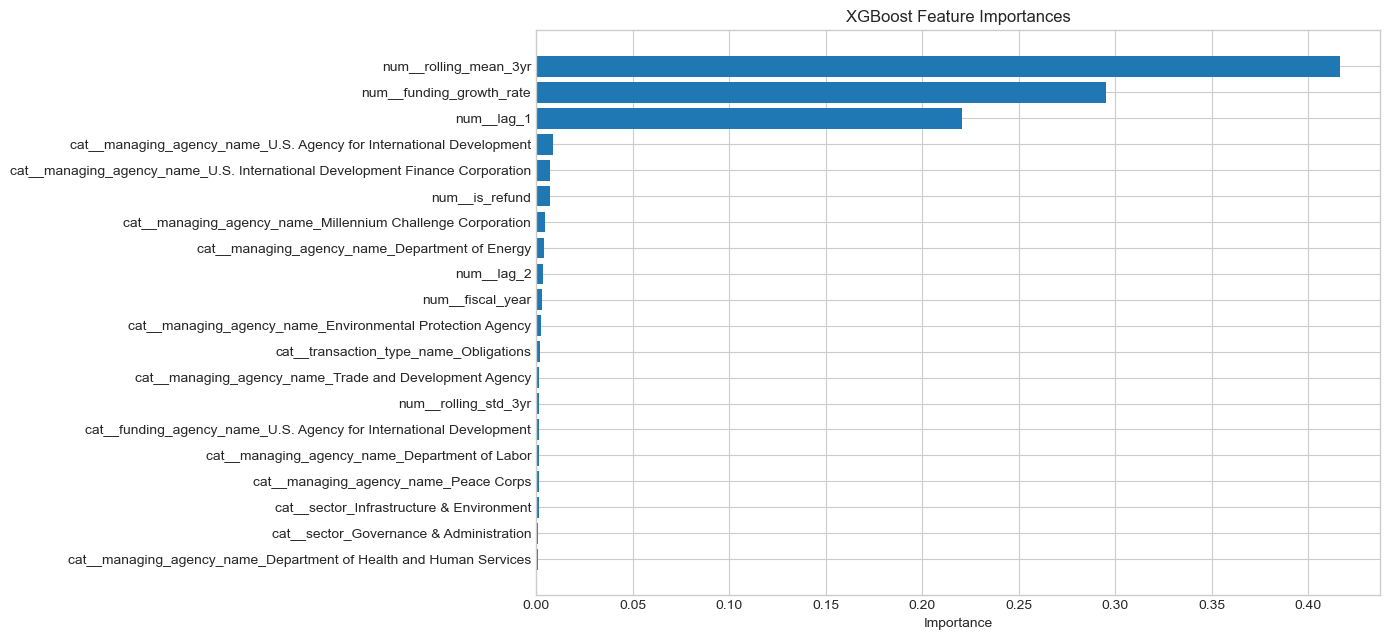

,Feature,Importance
52,num__rolling_mean_3yr,0.416364
54,num__funding_growth_rate,0.295057
50,num__lag_1,0.220567
17,cat__managing_agency_name_U.S. Agency for International Development,0.008782
18,cat__managing_agency_name_U.S. International Development Finance Corporation,0.007157
49,num__is_refund,0.007106
14,cat__managing_agency_name_Millennium Challenge Corporation,0.004523
3,cat__managing_agency_name_Department of Energy,0.004203
51,num__lag_2,0.003572
48,num__fiscal_year,0.003063


In [29]:
# Extract the tuned XGBoost pipeline
best_xgb = best_models['XGBoost']

# Extract trained model and feature names
xgb_model = best_xgb.named_steps['model']
feature_names = best_xgb.named_steps['preprocessor'].get_feature_names_out()

# Compute importances
importances = xgb_model.feature_importances_
feat_imp_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15
plt.figure(figsize=(14,6.5))
plt.barh(feat_imp_xgb.head(20)['Feature'], feat_imp_xgb.head(20)['Importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

feat_imp_xgb.head(20)

### *Interpretation:*

The XGBoost model highlights that **historical funding behavior** is the key driver of future allocations, while agency or sector attributes play a much smaller role.

#### **Key Takeaways**

- **rolling_mean_3yr (0.416)**  
  - The 3-year moving average of aid dominates the model.  
  - Funding tends to follow recent trends - high or low spending patterns persist across years.

- **funding_growth_rate (0.295)**  
  - The rate at which funding changes is highly influential.  
  - Strong upward or downward movements in recent years heavily shape future expectations.

- **lag_1 (0.221)**  
  - The previous year’s funding significantly impacts the next.  
  - This reflects continuity and institutional momentum in funding decisions.

- **Agency indicators (0.004–0.009)**  
  - Different agencies (e.g., USAID, DFC, MCC) have small but measurable effects.  
  - However, which agency handles the funds matters far less than overall trends.

- **is_refund (0.007)**  
  - Refund transactions play a minor role, suggesting occasional adjustments or corrections in the funding process.

- **fiscal_year (0.003)**  
  - The fiscal year itself has low predictive value - time effects are already captured through rolling averages and lagged terms.

- **rolling_std_3yr (0.001)**  
  - Variability in recent funding is not a strong predictor.  
  - Stable, consistent patterns matter more than short-term volatility.

- **Sector indicators (~0.001)**  
  - Sector-based effects are minimal, implying that funding moves together across sectors rather than diverging sharply.

#### **Implication:**

- The model emphasizes **momentum and historical consistency** in aid allocation.  
- **Temporal features** (trends, averages, and lags) overwhelmingly explain future funding.  
- **Categorical features** like sector or agency add nuance but do not drive the main pattern.  
- Policymakers seem to adjust budgets **gradually** rather than making abrupt shifts year to year.

# SAVE BEST MODEL

In [ ]:
import joblib

# Save the full pipeline
joblib.dump(best_xgb, 'best_xgb_pipeline.pkl')

print("XGBoost pipeline saved successfully as 'best_xgb_pipeline.pkl'")

XGBoost pipeline saved successfully as 'best_xgb_pipeline.pkl'
